In [21]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.flattening_transform import flattening_transform, reindex_transform

def create_cell_ind_to_grid(H, W):
    w, h = torch.meshgrid(
        torch.arange(H),
        torch.arange(W),
        indexing="ij"
    )

    d = (H - 1 - w) + h          # diagonal index
    order = torch.argsort(
        d.flatten() * max(H, W) + w.flatten()
    )

    out = torch.empty(H * W, dtype=torch.long)
    out[order] = torch.arange(H * W)

    return out.view(H, W)

def create_flattening_index_set(H,W, continuous_traversal=False):
    h, w = torch.meshgrid(
        torch.arange(H),
        torch.arange(W),
        indexing="ij"
    )
    if continuous_traversal:
        diag_mask = h+w
        diag_mask = torch.ones_like(diag_mask)-diag_mask%2

        sgn_fn = torch.where(diag_mask%2==1, 1, -1)

        diag_key = ((1+sgn_fn/(2*H))*h + w).flip(0)
    else:
        diag_key = (h + (1+1/(2*W))*(w)).flip(0)

    return torch.argsort(diag_key.flatten())



def train_loop(dataloader, nn, optimizer, loss_fn):
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0.0
    for batch, (x, t) in enumerate(dataloader):
        y_pred = nn(x)

        loss = loss_fn(y_pred,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return(train_loss)

def test_loop(dataloader, nn, loss_fn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    with torch.no_grad():
        for x, t in dataloader:
            y_pred = nn(x)

            loss = loss_fn(y_pred,t)

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    return(test_loss)


class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x

class MLP_block(nn.Module):
    def __init__(
            self, 
            insize, 
            outsize, 
            activation, 
            normalization=None, 
            residual_connection=None, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        self.residual_connection = residual_connection
        components = [nn.Linear(insize, outsize), activation()]
        if normalization:
            components.append(normalization(outsize))
        if Dropout:
            components.append(nn.Dropout(p=p))
        self.layer = nn.Sequential(*components)
        if residual_connection:
            self.layer = resblock(self.layer)

            
    def forward(self, x):
        return self.layer(x) 
    
class const_featuresize_MLP(nn.Module):
    def __init__(
            self, 
            width, 
            depth, 
            activation,
            residual_connection=False, 
            normalization=False, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.append(
                MLP_block(
                    insize=width, 
                    outsize=width, 
                    activation=activation, 
                    normalization=normalization, 
                    residual_connection=residual_connection, 
                    Dropout=Dropout, 
                    p=p
                )
            )
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    


class sMLP(torch.nn.Module):
    def __init__(
            self, 
            in_features, 
            cdim_MLP_width, 
            cdim_MLP_depth, 
            out_features, 
            activation, 
            residual_connection=False, 
            normalization=False, 
            Dropout=False, 
            p=0.5, 
            dir=None
        ):
        super().__init__()
        if cdim_MLP_depth == 0:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                )
            )
        if cdim_MLP_depth == 1:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=out_features, 
                    depth=1, 
                    activation=activation, 
                    residual_connection=residual_connection
                )
            )
        else:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=cdim_MLP_width, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=cdim_MLP_width, 
                    depth=cdim_MLP_depth, 
                    activation=activation, 
                    residual_connection=residual_connection, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                MLP_block(
                    insize=cdim_MLP_width, 
                    outsize=out_features, 
                    activation=activation, 
                )
        )
        if dir:
            self.load_state_dict(torch.load(dir, weights_only=True))

    def forward(self, x):
        y_pred = self.ffwd(x)
        return y_pred




def train(
        device,
        dtype,
        model_init_dir,
        in_features,
        width,
        depth,
        out_features,
        activation,
        residual_connection,
        normalization,
        Dropout,
        p,
        loss_fn,
        optimizer, 
        scheduler,
        step_size,
        epochs, 
        train_set_input_dir,
        train_set_target_dir,
        test_set_input_dir,
        test_set_target_dir,
        batch_size,
        save_steps = 10,
        train_loss_file = None, 
        test_loss_file = None,
        model_dir = None,
        figure = None,
        figure_file = None
):
    H,W = 32,32
    transform_flat_key = create_flattening_index_set(H=H+2,W=W+2, continuous_traversal=False)
    transform = flattening_transform(flat_key=transform_flat_key, C=13)
    train_set = dataset(
        input_dir=train_set_input_dir, 
        target_dir=train_set_target_dir, 
        transform=transform, 
        target_transform=None, 
        device=device
    )

    test_set = dataset(
        input_dir=test_set_input_dir, 
        target_dir=test_set_target_dir, 
        transform=transform, 
        target_transform=None, 
        device=device
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    try:
        model = sMLP(
            in_features=in_features, 
            out_features=out_features, 
            activation=activation, 
            cdim_MLP_width=width,
            cdim_MLP_depth=depth, 
            residual_connection=residual_connection, 
            normalization=normalization,
            Dropout=Dropout,
            p=p,
            dir=model_init_dir
        ).to(
            device=device, 
            dtype=dtype
        )
    except:
        model = sMLP(
            in_features=in_features, 
            out_features=out_features, 
            activation=activation, 
            cdim_MLP_width=width,
            cdim_MLP_depth=depth, 
            residual_connection=residual_connection, 
            normalization=normalization,
            dir=None
        ).to(
            device=device, 
            dtype=dtype
        )
        torch.save(model.state_dict(), model_init_dir)
    optimizer = optimizer(model.parameters())
    scheduler = scheduler(optimizer=optimizer, step_size=step_size)
    train_loss_array = np.array([])
    test_loss_array = np.array([])
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_array = np.append(
            train_loss_array, 
            train_loop(
                dataloader=train_loader,
                nn=model,
                optimizer=optimizer,
                loss_fn=loss_fn
                )
        )
        scheduler.step()
        if model_dir and t%save_steps==0:
            torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')
        test_loss_array = np.append(
            test_loss_array,
            test_loop(
                dataloader=test_loader, 
                nn=model, 
                loss_fn=loss_fn
            )
        )
    if train_loss_file:
        np.save(file=train_loss_file, arr=train_loss_array)
    if test_loss_file:
        np.save(file=test_loss_file, arr=test_loss_array)
    if figure:
        clear_output()
        x= np.linspace(1,len(train_loss_array),len(train_loss_array))

        plt.plot(x, train_loss_array, label= 'Train loss', linestyle='-',)
        plt.plot(x, test_loss_array,label='Test loss', linestyle='-')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        if figure_file:
            plt.savefig(figure_file)
        plt.show()
    return train_loss_array, test_loss_array

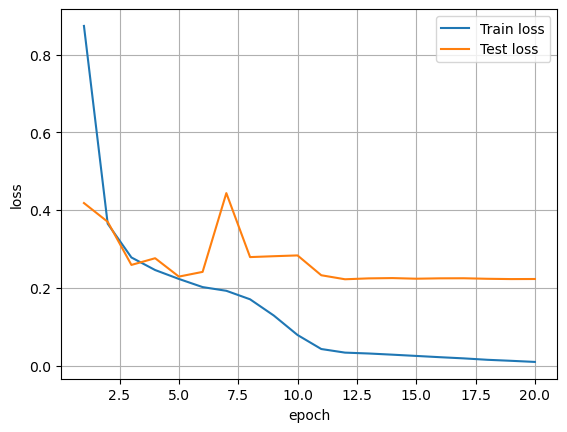

In [92]:


train_loss_d1_plain, test_loss_d1_plain, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d1_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=2000,
    depth = 0,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 20, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

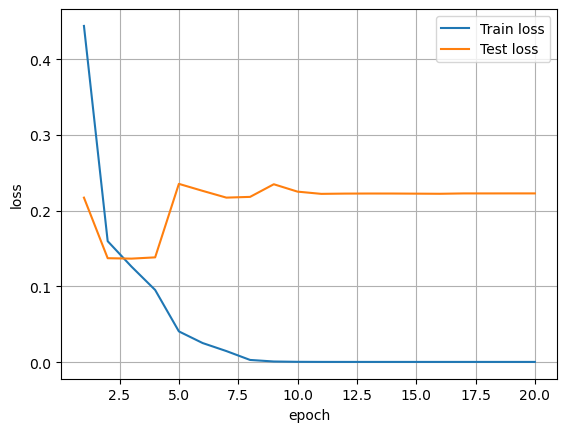

In [28]:

train_loss_d4_plain, test_loss_d4_plain, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d4_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=2000,
    depth = 3,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 20, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

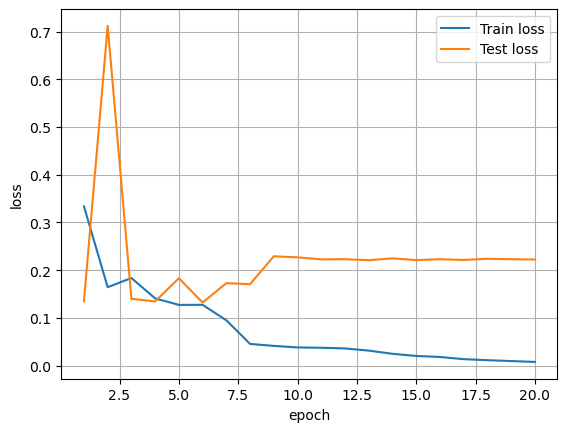

In [29]:

train_loss_d6_plain, test_loss_d6_plain, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d6_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=2000,
    depth = 5,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 20, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

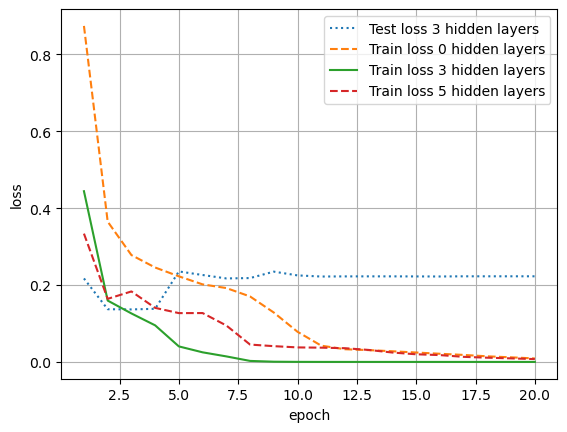

In [118]:
x= np.linspace(1,len(train_loss_d1_plain),len(train_loss_d1_plain))

#plt.plot(x, test_loss_d1_plain,label='Test loss 1 layer', linestyle='-.')
plt.plot(x, test_loss_d4_plain,label='Test loss 3 hidden layers', linestyle=':', linewidth=1.5)
#plt.plot(x, test_loss_d6_plain,label='Test loss 6 layer', linestyle=':')
plt.plot(x, train_loss_d1_plain, label= 'Train loss 0 hidden layers', linestyle='--',)
plt.plot(x, train_loss_d4_plain, label= 'Train loss 3 hidden layers', linestyle='-',)
plt.plot(x, train_loss_d6_plain, label= 'Train loss 5 hidden layers', linestyle='--',)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.savefig('example_3_1_plain_loss.png')
plt.show()

In [131]:
train_loss_d4_plain[-1]

0.0003422075242269784

In [130]:
0.139/400

0.00034750000000000004

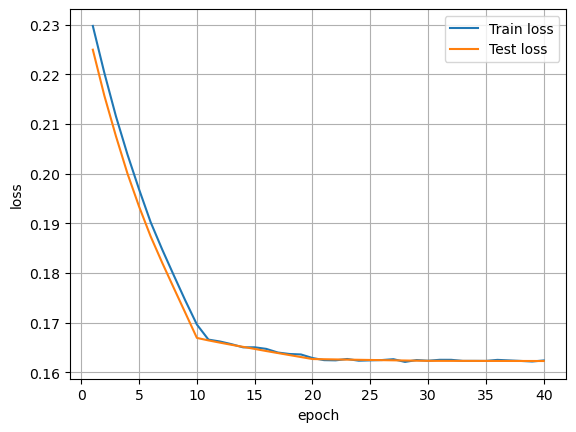

In [96]:

train_loss_d3_w1, test_loss_d3_w1, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d3_w1_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width= 1,
    depth = 3,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 40, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

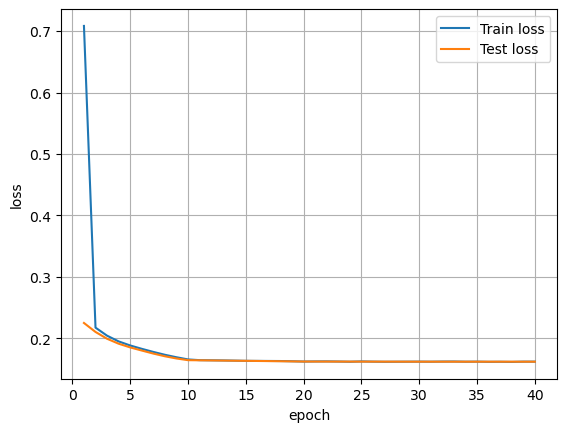

In [98]:

train_loss_d3_w1_res_drop, test_loss_d3_w1_res_drop, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d3_w1_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width= 2,
    depth = 3,
    activation = nn.LeakyReLU,
    residual_connection = True,
    normalization = None,
    Dropout = True,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 40, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

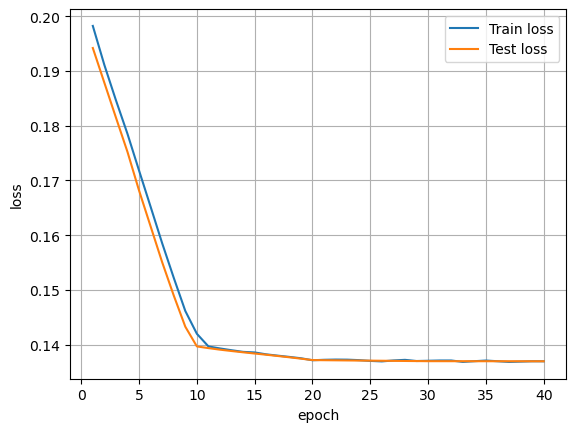

In [111]:

train_loss_d4_w2, test_loss_d4_w2, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d4_w2_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width= 2,
    depth = 4,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 40, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

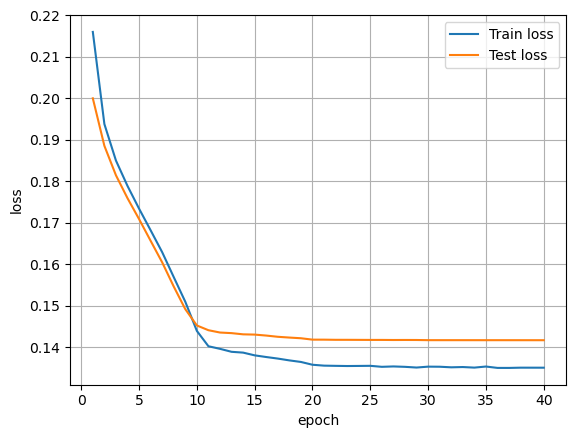

In [110]:

train_loss_d4_w2_res_drop, test_loss_d4_w2_res_drop, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d4_w2_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width= 2,
    depth = 4,
    activation = nn.LeakyReLU,
    residual_connection = True,
    normalization = None,
    Dropout = True,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 40, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)

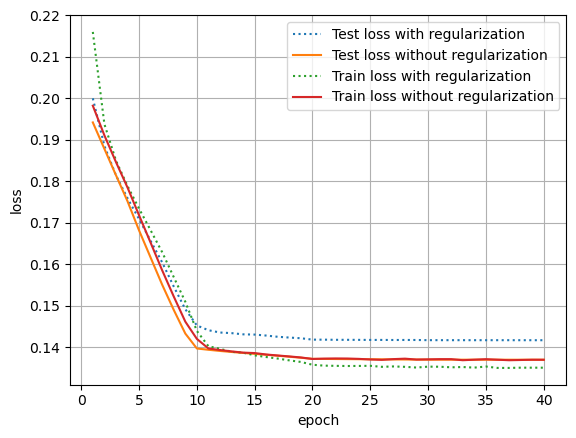

In [119]:
x= np.linspace(1,len(train_loss_d4_w2_res_drop),len(train_loss_d4_w2_res_drop))


plt.plot(x, test_loss_d4_w2_res_drop,label='Test loss with regularization', linestyle=':', linewidth=1.5)
plt.plot(x, test_loss_d4_w2, label= 'Test loss without regularization', linestyle='-',)
plt.plot(x, train_loss_d4_w2_res_drop, label= 'Train loss with regularization', linestyle=':',)
plt.plot(x, train_loss_d4_w2, label= 'Train loss without regularization', linestyle='-',)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.savefig('example_3_1_reduced_width_loss.png')
plt.show()